In [1]:
state = 'AR'    # 2-letter state code
k = 4           # number of districts

In [2]:
# Read county graph from the json file "<state>_county.json"
filepath = 'C:\\districting-data-2020\\'
filename = state + '_county.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [3]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
L = math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i,j] equals one when county i is assigned to district j
x = m.addVars(G.nodes, k, vtype=GRB.BINARY)  

# y[u,v,j] equals one when arc (u,v) is cut because u->j but not v->j
y = m.addVars(DG.edges, k, vtype=GRB.BINARY) 

# z[j] is inverse Polsby-Popper score for district j
z = m.addVars(k)

# A[j] = area of district j
A = m.addVars(k)

# P[j] = perimeter of district j
P = m.addVars(k)

for j in range(k):
    z[j].lb = 0
    A[j].lb = 0
    P[j].lb = 0

Set parameter Username
Academic license - for non-commercial use only - expires 2023-01-01


In [5]:
# objective is to minimize sum of inverse Polsby-Popper scores
coef = 1 / ( 2 * math.pi )
m.setObjective( coef * gp.quicksum( z[j] for j in range(k) ), GRB.MINIMIZE )

In [6]:
# add SOCP constraints relating inverse Polsby-Popper score z[j] to area and perimeter
m.addConstrs( P[j] * P[j] <= 2 * A[j] * z[j] for j in range(k) )

# add constraints on areas A[j] 
m.addConstrs( A[j] == gp.quicksum( G.nodes[i]['area'] * x[i,j] for i in G.nodes ) for j in range(k) )

# add constraints on perimeters P[j]
for j in range(k):
    m.addConstr( P[j] == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v,j] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i,j] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum( x[i,j] for j in range(k)) == 1 for i in G.nodes )

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v,j] for u,v in DG.edges for j in range(k) )

m.update()

In [8]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

f = m.addVars( DG.edges )

In [9]:
def compute_big_M(G,U):
    mm = gp.Model()
    mm.Params.OutputFlag = 0
    mx = mm.addVars( G.nodes, vtype=GRB.BINARY )
    mm.setObjective( gp.quicksum( mx ), GRB.MAXIMIZE )
    mm.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * mx[i] for i in G.nodes ) <= U )
    mm.optimize()
    return round(mm.objVal) - 1

In [10]:
# The big-M proposed by Hojny et al.
# M = G.number_of_nodes() - k + 1

# A stronger big-M
M = compute_big_M(G,U)

# Each district j should have one root
#m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )
# ^a stronger form of this appears in orbitope EF, so skip it.

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[u,v] + f[v,u] <= M * ( 1 - gp.quicksum( y[u,v,j] for j in range(k) ) ) for u,v in DG.edges )

m.update()

In [11]:
# helper functions for symmetry handling and variable fixing
def sort_by_second(val):
    return val[1]

def find_ordering(B, G):
    V_B_with_population = [(i,G.nodes[i]['TOTPOP']) for i in G.nodes if i not in B]
    V_B_with_population.sort(key=sort_by_second,reverse=True)
    return [v for (v,p) in V_B_with_population] + B

def solve_maxB_problem(G, L, k):
    m = gp.Model()
    m.params.LogToConsole = 0 # keep log to a minimum
    q = k
    
    # X[i,j]=1 if vertex i is assigned to bin j
    X = m.addVars(G.nodes, range(q), vtype=GRB.BINARY)
    
    # B[i]=1 if vertex i is selected in set B
    B = m.addVars(G.nodes, vtype=GRB.BINARY)
   
    # assignment constraints            
    m.addConstrs( gp.quicksum(X[i,j] for j in range(q)) == B[i] for i in G.nodes )
                
    # bin population should be less than L
    m.addConstrs( gp.quicksum(G.nodes[i]['TOTPOP'] * X[i,j] for i in G.nodes) <= L-1 for j in range(q) )
    
    # bins shouldn't touch each other
    m.addConstrs( X[u,j] + B[v] <= 1 + X[v,j] for u,v in G.edges for j in range(q) )
    m.addConstrs( X[u,j] + B[v] <= 1 + X[v,j] for v,u in G.edges for j in range(q) )
    
    # objective is to maximize size of set B
    m.setObjective( gp.quicksum( B ), GRB.MAXIMIZE )
    
    m.Params.MIPFocus = 1 # turn on MIPFocus
    m.Params.timeLimit = 60 # 60-second time limit
    m.optimize()
    
    if m.status in { GRB.OPTIMAL, GRB.TIME_LIMIT }:
        B_sol = [i for i in DG.nodes if B[i].x > 0.5 ]
    else:
        B_sol = list()
    print("Size of B =",len(B_sol))
    return B_sol
    
# how many people are reachable from v in G[S]? Uses BFS
def reachable_population(G, S, v):
    pr = 0 # population reached
    if not S[v]:
        return 0
    
    visited = [False for i in G.nodes]
    child = [v]
    visited[v] = True
    while child:
        parent = child
        child = list()
        for i in parent:
            pr += G.nodes[i]['TOTPOP']
            for j in G.neighbors(i):
                if S[j] and not visited[j]:
                    child.append(j)
                    visited[j] = True
    return pr     

In [12]:
# APPLY FIXINGS
B = solve_maxB_problem(G, L, k)
ordering = find_ordering(B, G)

Size of B = 64


In [13]:
# D-fixing
for p in range(G.number_of_nodes()):
    i = ordering[p]
    for j in range(p+1,k):
        x[i,j].UB = 0

In [14]:
# L-fixing

# find "back" of ordering B = {v_q, v_{q+1}, ..., v_{n-1} }
n = G.number_of_nodes()
S = [False for v in G.nodes]
for p in range(n):
    v_pos = n - p - 1
    v = ordering[v_pos]
    S[v] = True
    pr = reachable_population(G, S, v)
    if pr >= L:
        q = v_pos + 1
        break

# none of the vertices at back (in B) can root a district. 
for p in range(q,n):
    i = ordering[p]
    for j in range(k):
        r[i,j].UB = 0

# vertex v_{q-1} cannot root districts {0, 1, ..., k-2}
# vertex v_{q-2} cannot root districts {0, 1, ..., k-3}
# ... 
# vertex v_{q-t} cannot root districts {0, 1, ..., k-t-1}
# ...
# vertex v_{q-(k-1)} cannot root district {0}
for t in range(1,k):
    i = ordering[q-t]
    for j in range(k-t):
        r[i,j].UB = 0

In [15]:
# U-fixing
DG = nx.DiGraph(G)
for (i,j) in DG.edges:
    DG[i][j]['ufixweight'] = G.nodes[j]['TOTPOP'] # weight of edge (i,j) is population of its head j

for j in range(k):

    v = ordering[j]
    dist = nx.shortest_path_length(DG,source=v,weight='ufixweight')

    if j == 0:
        min_dist = U+1
    else:
        min_dist = min( dist[ordering[t]] + G.nodes[v]['TOTPOP'] for t in range(j) )

    if min_dist <= U:
        break
    
    r[v,j].LB = 1
    x[v,j].LB = 1

    for t in range(k):
        if t != j:
            x[v,t].UB = 0

    for i in DG.nodes:
        if i != v:
            r[i,j].UB = 0

    for i in DG.nodes:
        if i != v and dist[i] + G.nodes[v]['TOTPOP'] > U:
            x[i,j].UB = 0

In [16]:
# cut edge variable fixings
for u,v in G.edges:
    for j in range(k):
        if x[u,j].UB < 0.5 or x[v,j].LB > 0.5:
            y[u,v,j].UB = 0
        elif x[u,j].LB > 0.5 and x[v,j].UB < 0.5:
            y[u,v,j].LB = 1

In [17]:
# add partitioning orbitope EF
s = m.addVars(G.nodes, k)
u = m.addVars(G.nodes, k)
w = m.addVars(G.nodes, k) 

m.addConstrs(x[i,j] == s[i,j]-s[i,j+1] for i in G.nodes for j in range(k-1))
m.addConstrs(x[i,k-1] == s[i,k-1] for i in G.nodes)

m.addConstrs(r[ordering[0],j] == w[ordering[0],j] for j in range(k))
m.addConstrs(r[ordering[i],j] == w[ordering[i],j] - w[ordering[i-1],j] for i in range(1,G.number_of_nodes()) for j in range(k))

m.addConstrs(r[i,j] <= x[i,j] for i in G.nodes for j in range(k))
m.addConstrs(s[i,j] <= w[i,j] for i in G.nodes for j in range(k))

m.addConstrs(u[ordering[i],j]+r[ordering[i],j] == u[ordering[i+1],j] + r[ordering[i+1],j+1] for i in range(0,G.number_of_nodes()-1) for j in range(k-1))
m.addConstrs(u[ordering[i],k-1]+r[ordering[i],k-1] == u[ordering[i+1],k-1] for i in range(0,G.number_of_nodes()-1))
m.addConstrs(u[ordering[G.number_of_nodes()-1],j]+r[ordering[G.number_of_nodes()-1],j] == 0 for j in range(k-1))

r[ordering[0],0].LB=1
m.addConstr( u[ordering[G.number_of_nodes()-1],k-1] + r[ordering[G.number_of_nodes()-1],k-1]==1 )  

<gurobi.Constr *Awaiting Model Update*>

In [18]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 3886 rows, 3432 columns and 15479 nonzeros
Model fingerprint: 0xf33d9d43
Model has 4 quadratic constraints
Variable types: 1296 continuous, 2136 integer (2136 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+05]
  QMatrix range    [1e+00, 2e+00]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve removed 1649 rows and 1168 columns
Presolve time: 0.03s
Presolved: 2237 rows, 2264 columns, 10911 nonzeros
Presolved model has 4 quadratic constraint(s)
Variable types: 396 continuous, 1868 integer (1854 binary)

Root relaxation: objective 0.000000e+00, 1307 iterations, 0.03 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000

In [19]:
print("The objective value is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The objective value is 13.270587256343116
District 0 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 1 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 2 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'Lincoln', 'Scott', 'Hot Spring', 'Columbia', 'Ouachita', 'Yell', 'Calhoun', 'Phillips']

District 3 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Rando

In [20]:
# Let's draw it on a map
import geopandas as gpd

In [21]:
# Read county shapefile from "<state>_county.shp"
filename = state + '_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

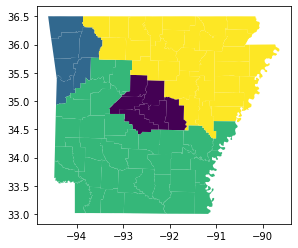

In [22]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()